# Imports

In [34]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import scipy.stats as stats
from IPython.display import IFrame

# Initializations

In [2]:
df = pd.read_csv("2024NYCMARATHONRESULTS.csv")

# Table Of Contents:
* [A) Understanding the dataset](#A)
* [B) Cleaning & Transforming the data](#B)
    * [B.1 Removing irrelevant columns](#B1)
    * [B.2 Removing NA values](#B2)
    * [B.3 Fixing and Converting Datatypes](#B3)
* [C) Demographic Analysis](#C)
    * [C.1 Gender Distribution](#C1)
    * [C.2 Age Distribution](#C2)
    * [C.3 Age Group Distribution](#C3)
    * [C.4 Where Are Runners From?](#C4)
    * [C.5 Which States Are The American Runners From?](#C5)
* [D) Performance](#D)
    * [D.1 Was There A Performance Difference Between Genders?](#D1)
        * [D.1.1 Hypothesis Testing](#D2)
    * [D.2 Which Age Groups Performed Better?](#D2)
    * [D.3 Does Age Have Any Relationship to Performance?](#D3)
    * [D.4 Does More Experience Improve Performace?](#D4)
* [E) Conclusion](#E)
 


# A) Understanding the dataset <a class="anchor" id="A"></a>
<ol>
  <li>See datatypes</li>
  <li>Understand missing values</li>
  <li>Verify basic statistics of each column</li>
</ol>

In [3]:
df.head()

,runnerId,firstName,bib,age,gender,city,countryCode,stateProvince,iaaf,overallPlace,overallTime,pace,genderPlace,ageGradeTime,ageGradePlace,ageGradePercent,racesCount
0,41771195,Abdi,7.0,35,M,Nijmegen,NLD,NaN,NED,1,2:07:39,4:53,1,6:57,1,96.86,4
1,41775746,Evans,3.0,35,M,Kapsabet,KEN,-,KEN,2,2:07:45,4:53,2,7:03,2,96.79,2
2,41766254,Albert,2.0,30,M,Kapkitony,KEN,NaN,KEN,3,2:08:00,4:53,3,8:00,3,96.06,5
3,41763160,Tamirat,1.0,33,M,Addis Ababa,ETH,NaN,ETH,4,2:08:12,4:54,4,8:02,4,96.03,4
4,41757406,Geoffrey,6.0,31,M,Kapchorwa District,KEN,-,KEN,5,2:08:50,4:55,5,8:50,6,95.44,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55524 entries, 0 to 55523
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   runnerId         55524 non-null  int64  
 1   firstName        55524 non-null  object 
 2   bib              55512 non-null  float64
 3   age              55524 non-null  int64  
 4   gender           55512 non-null  object 
 5   city             55462 non-null  object 
 6   countryCode      55512 non-null  object 
 7   stateProvince    55231 non-null  object 
 8   iaaf             55511 non-null  object 
 9   overallPlace     55524 non-null  int64  
 10  overallTime      55524 non-null  object 
 11  pace             55524 non-null  object 
 12  genderPlace      55524 non-null  int64  
 13  ageGradeTime     55524 non-null  object 
 14  ageGradePlace    55524 non-null  int64  
 15  ageGradePercent  55524 non-null  float64
 16  racesCount       55524 non-null  int64  
dtypes: float64(2

In [5]:
df.isna().sum()

runnerId             0
firstName            0
bib                 12
age                  0
gender              12
city                62
countryCode         12
stateProvince      293
iaaf                13
overallPlace         0
overallTime          0
pace                 0
genderPlace          0
ageGradeTime         0
ageGradePlace        0
ageGradePercent      0
racesCount           0
dtype: int64

In [6]:
df.describe()

,runnerId,bib,age,overallPlace,genderPlace,ageGradePlace,ageGradePercent,racesCount
count,5.552400e+04,55512.000000,55524.000000,55524.00000,55524.000000,55524.000000,55524.000000,55524.000000
mean,4.177795e+07,33128.603707,39.893596,27762.50000,13983.581712,13983.453119,52.361798,12.912488
std,1.605918e+04,18932.492867,11.609486,16028.54251,8287.204370,8287.420736,10.988954,30.013987
min,4.175012e+07,1.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000
25%,4.176405e+07,16975.750000,30.000000,13881.75000,6881.750000,6881.750000,44.930000,1.000000
50%,4.177796e+07,32991.500000,39.000000,27762.50000,13822.000000,13822.000000,51.740000,2.000000
75%,4.179186e+07,49419.250000,48.000000,41643.25000,20762.250000,20762.250000,59.030000,12.000000
max,4.180576e+07,67000.000000,88.000000,55524.00000,30696.000000,30696.000000,96.860000,1393.000000


# B) Cleaning & Transforming the data <a class="anchor" id="B"></a>
<ol>
  <li>Remove irrelevant columns</li>
  <li>Remove rows with missing values</li>
  <li>Convert <b>pace</b> and <b>overallTime</b> into a usable format</li>
</ol>

### B.1 Removing irrelevant columns <a class="anchor" id="B1"></a>

In [7]:
df = df.drop(columns=['ageGradeTime','bib','iaaf'])

ageGradeTime will not be used in the analysis due to its uneven distribution. Some runners have a value that is in minutes, and some in the tens of hours

bib numbers do not matter to this analysis. runnerId is a unique identifier

iaaf is the three letter country code, and is a duplicate of the countryCode column

### B.2 Removing NA Values <a class="anchor" id="B2"></a>

In [8]:
marathon = df.dropna(subset=["gender","countryCode"])

Although we have missing values for city and stateProvince, these are irrelevant since our geographic analysis will pivot on runners from the US, which have complete data.

In [9]:
marathon['pace'][-20:]

55504       23:05
55505       23:16
55506       23:19
55507       23:27
55508       23:37
55509       23:51
55510       23:56
55511    24:07:00
55512    24:17:00
55513    24:43:00
55514    25:01:00
55515    25:42:00
55516    26:02:00
55517    26:05:00
55518    26:05:00
55519    26:06:00
55520    26:39:00
55521    26:48:00
55522    26:50:00
55523    27:00:00
Name: pace, dtype: object

The dataset incorrectly converted paces of 24 minutes and above into an hourly format. We will consider this invalid and remove these instances

### B.3 Fixing and converting datatypes <a class="anchor" id="B3"></a>

In [10]:
invalid_times = marathon[(marathon['pace'].str.contains(r'^2[4-9]:', na=False))] # Paces that are above 24 hours
marathon = marathon.drop(invalid_times.index)

In [11]:
# Recoding Genders
marathon['gender'] = marathon['gender'].replace({
    'M': 'Male',
    'W': 'Female',
    'X': 'Non-Binary'
})

In [12]:
# Convert overallTime and pace variables to an Hours, Minutes and, Seconds format
marathon['overallTime'] = pd.to_timedelta(marathon['overallTime'].astype(str))
marathon['pace'] = '00:' + marathon['pace']
marathon['pace'] = pd.to_timedelta(marathon['pace'].astype(str))

# Create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 100]
labels = ['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '>70']
marathon['ageGroup'] = pd.cut(marathon['age'], bins=bins, labels=labels)

In [13]:
# Convert finish from datetime to a float (hours) for use in visualizations
marathon['finishTime_hours'] = marathon['overallTime'].dt.total_seconds() / 3600

# C) Demographic Analysis <a class="anchor" id="C"></a>

### C.1 Gender Distribution <a class="anchor" id="C1"></a>

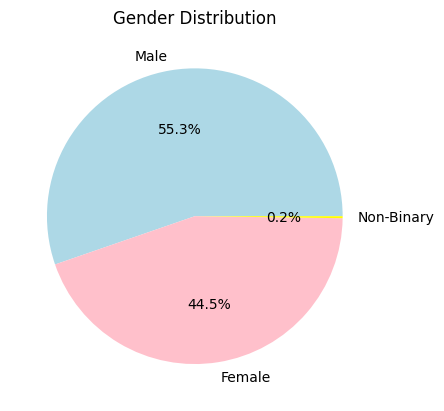

In [14]:
gender_counts = marathon['gender'].value_counts()

plt.pie(gender_counts, labels=gender_counts.index,autopct="%1.1f%%", colors=['lightblue', 'pink', 'yellow'])
plt.title('Gender Distribution')
plt.show()

### C.2 Age Distribution <a class="anchor" id="C2"></a>

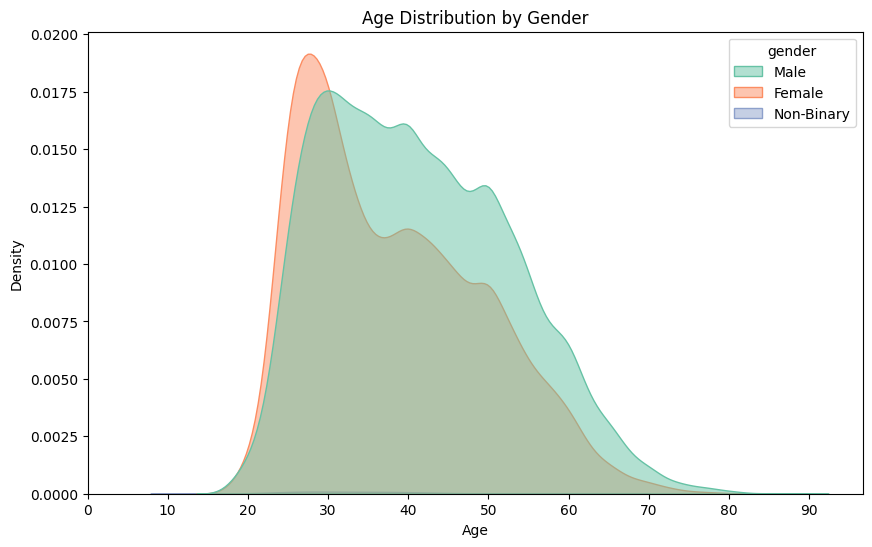

In [15]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=marathon, x='age', hue='gender', fill=True, palette='Set2', alpha=0.5)
plt.title('Age Distribution by Gender')
plt.xticks(range(0,100,10))
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

### C.3 Age Group Distribution <a class="anchor" id="C3"></a>

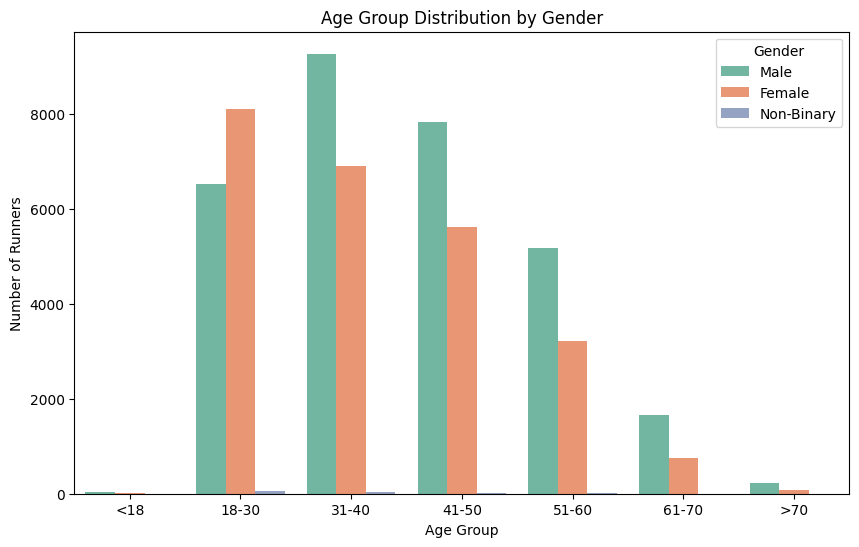

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(data=marathon, x='ageGroup', hue='gender', palette='Set2')
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Number of Runners')
plt.legend(title='Gender')
plt.show()

### C.4 Where Are Runners From? <a class="anchor" id="C4"></a>

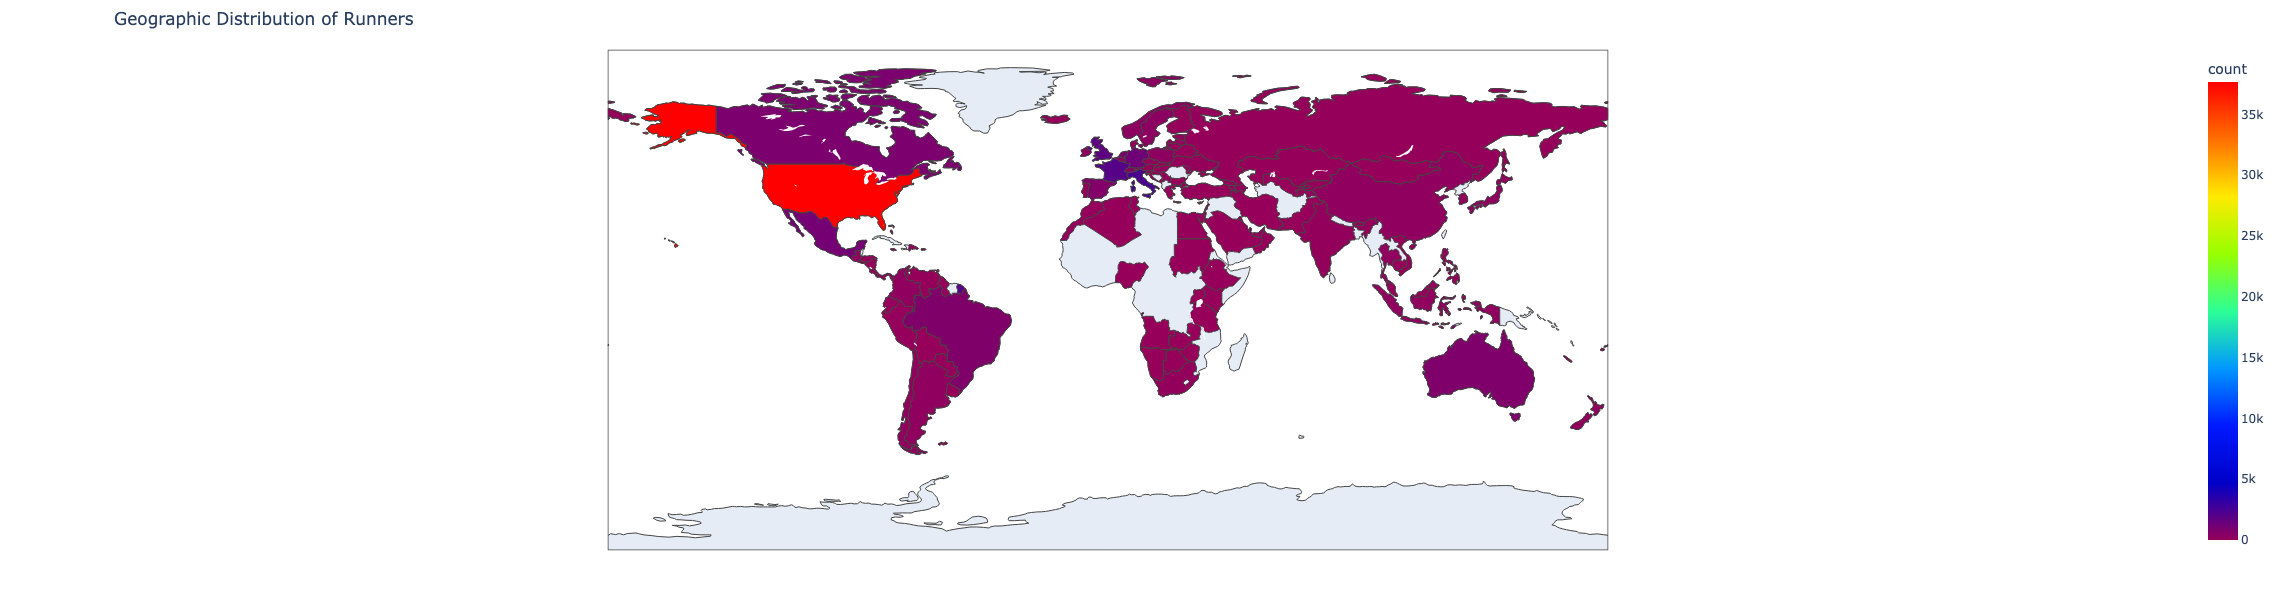

In [31]:
top_countries = marathon['countryCode'].value_counts().reset_index()
top_countries.columns = ['country', 'count']

fig = px.choropleth(
    top_countries, 
    locations='country', 
    locationmode='ISO-3', 
    color='count',
    title='Geographic Distribution of Runners',
    color_continuous_scale='Rainbow'
)
fig.update_layout(margin=dict(l=60, r=60, t=50, b=50), # Set dimensions so map is zoomed into
    width=1000,  
    height=600   
)

fig.show()
fig.write_html("Cloropleth1.html")


In [36]:
IFrame(src="Cloropleth1.html", width=1000, height=600)

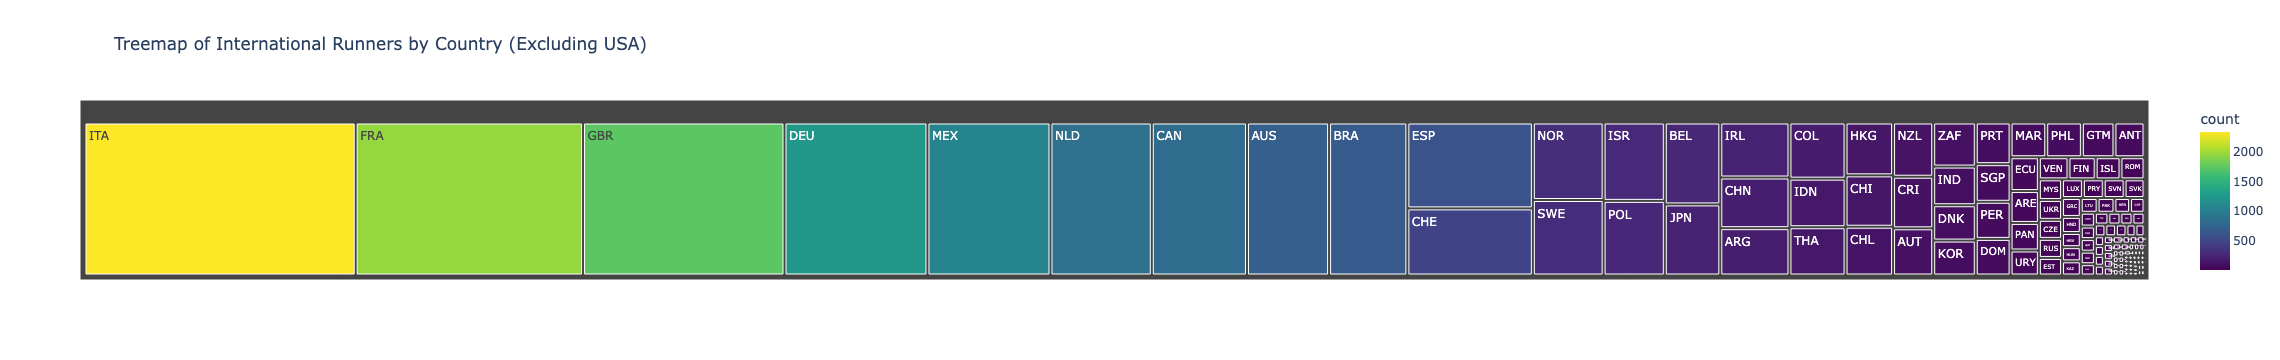

In [32]:
# It's clear that most runners are from the US, but what other countries are runners from
non_us = marathon[marathon['countryCode'] != 'USA']

country_counts = non_us['countryCode'].value_counts().reset_index()
country_counts.columns = ['country', 'count']


fig = px.treemap(country_counts, 
                 path=['country'], 
                 values='count',
                 title="Treemap of International Runners by Country (Excluding USA)",
                 color='count',
                 color_continuous_scale='Viridis')

fig.show()
fig.write_html("Treemap.html")


In [44]:
IFrame(src="Treemap.html", width=2000, height=500)

### C.5 Which States Are The American Runners From?<a class="anchor" id="C5"></a>

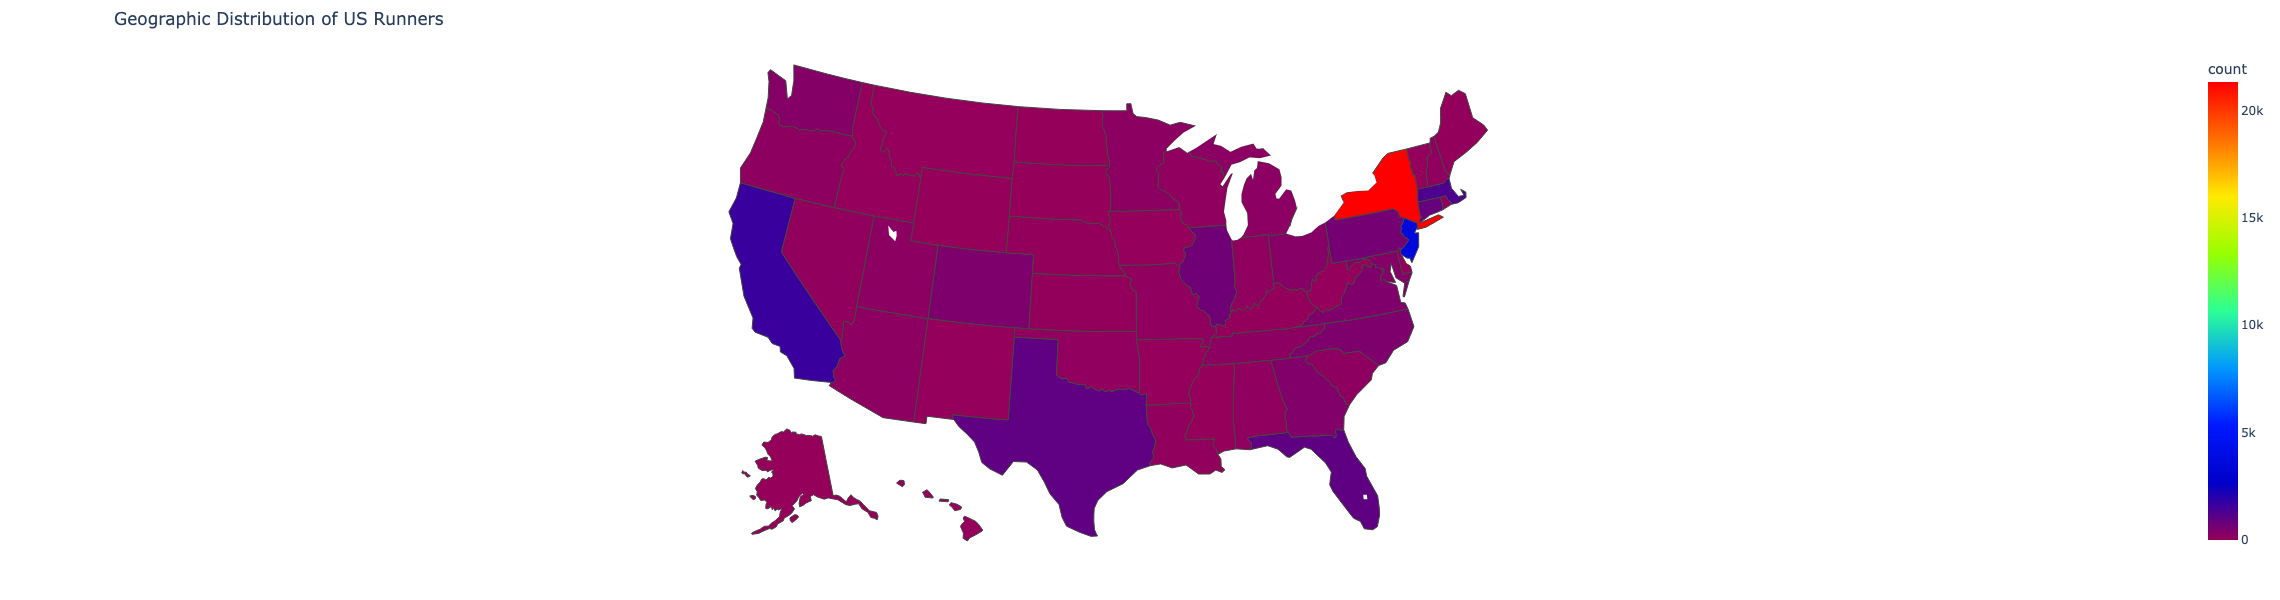

In [33]:
us_marathon = marathon[marathon['countryCode'] == 'USA']

state_counts = us_marathon['stateProvince'].value_counts().reset_index()
state_counts.columns = ['state', 'count']

fig = px.choropleth(
    state_counts,
    locations='state',  
    locationmode='USA-states',  
    color='count', 
    color_continuous_scale='Rainbow',  
    scope='usa',  
    title='Geographic Distribution of US Runners'
)


fig.update_layout(margin=dict(l=60, r=60, t=50, b=50),
    width=1000,  
    height=600   
)

fig.show()
fig.write_html("Cloropleth2.html")


In [37]:
IFrame(src="Cloropleth2.html", width=1000, height=600)

# D) Performance <a class="anchor" id="D"></a>

### D.1 Was There a Performance Difference Between Genders? <a class="anchor" id="D1"></a>

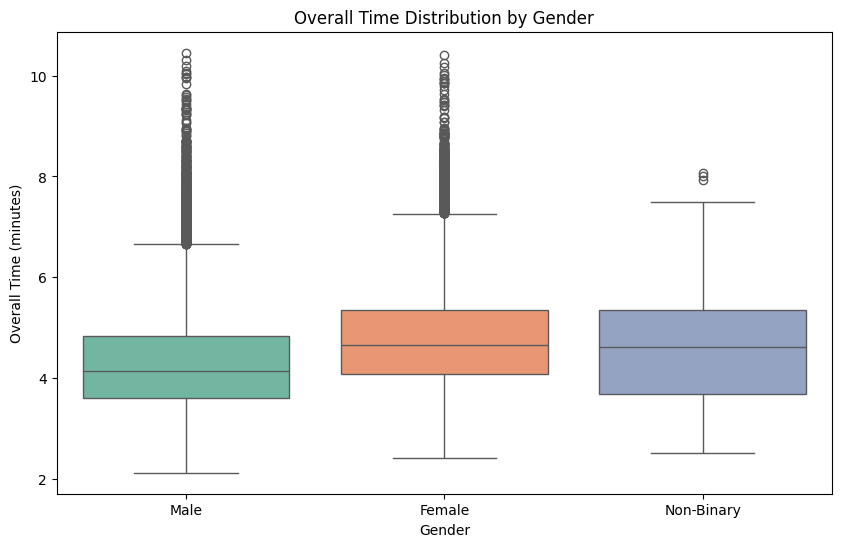

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=marathon, 
    x='gender', 
    y=marathon['finishTime_hours'], 
    hue = 'gender',
    palette= 'Set2'
)
plt.title('Overall Time Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Overall Time (minutes)')
plt.show()

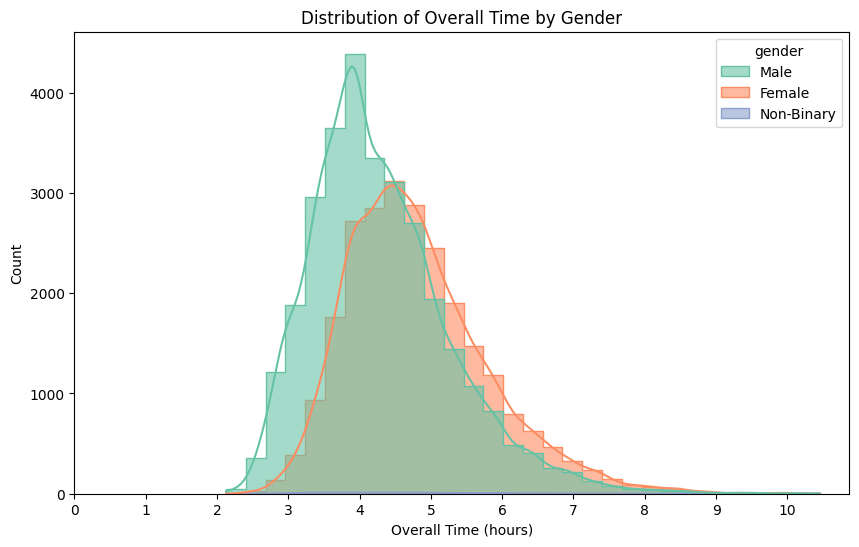

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=marathon, 
    x=marathon['finishTime_hours'],
    bins=30, 
    kde=True, 
    hue='gender',
    palette='Set2', 
    alpha=0.6, 
    element='step')


plt.title("Distribution of Overall Time by Gender")
plt.xlabel('Overall Time (hours)')
plt.ylabel('Count')

plt.xticks(ticks=range(0, int(marathon['finishTime_hours'].max()) + 1))

plt.show()

#### D.1.1 Hypothesis Testing  <a class="anchor" id="D11"></a>

Hypotheses:
- Null Hypothesis (H₀): There is no difference in the mean finishing times between genders.
- Alternative Hypothesis (H₁): There is a difference in the mean finishing times between genders.

Significance Level = 0.05

<i><u>Note: This test will only consider Male and Female since the Non-Binary category does not have sufficient data</u></i>

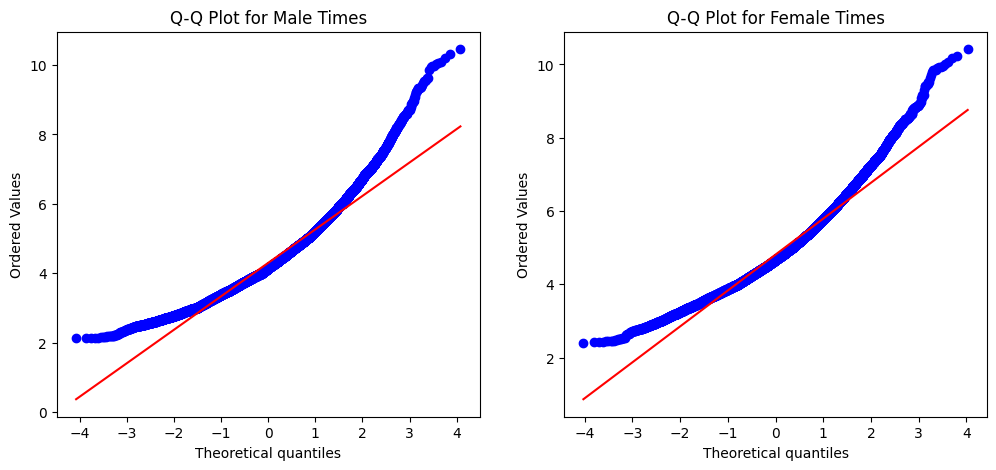

Levene's Test for equal variances:
Statistic: 6.283, p-value: 0.012


In [22]:
# Separating Data
marathon_gender = marathon[marathon['gender'].isin(['Male', 'Female'])]

male_times = marathon_gender[marathon_gender['gender'] == 'Male']['finishTime_hours']
female_times = marathon_gender[marathon_gender['gender'] == 'Female']['finishTime_hours']


# Checking Normality with a Q-Q Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
stats.probplot(male_times, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot for Male Times")
stats.probplot(female_times, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot for Female Times")
plt.show()

# Checking whether variances are equal
levene_test = stats.levene(male_times, female_times)
print("Levene's Test for equal variances:")
print(f"Statistic: {levene_test.statistic:.3f}, p-value: {levene_test.pvalue:.3f}")

Since the data violates the normality assumption and the variances between male and female finishing times are significantly different (p < 0.05), we cannot use a standard t-test. 

We will instead use the Mann-Whitney U test (a non-parametric test)

In [23]:
# Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(male_times, female_times, alternative="two-sided")

print(f"Mann-Whitney U Test:\nU Statistic = {u_stat:.3f}, p-value = {p_value:.5f}")

Mann-Whitney U Test:
U Statistic = 261973684.000, p-value = 0.00000


In [24]:
# Probability that a randomly chosen male time is higher than a female time
n1, n2 = len(male_times), len(female_times)
cles = u_stat / (n1 * n2)  

print(f"Common Language Effect Size (CLES): {cles:.3f}")

Common Language Effect Size (CLES): 0.346




<b>Interpretation:</b> Based on these results, we can conclude that there is a statistically significant difference in the finishing times between Male and Female runners in the NYC 2024 Marathon. Given the large U-statistic and the near-zero p-value, the performance difference between genders is not due to random chance. The CLES tells us that There is a 34.6% probability that a randomly chosen male has a slower finishing time than a randomly chosen female. This conclusion is supported by the density and box plots.

### D.2 Which Age Groups Performed Better?<a class="anchor" id="D2"></a>

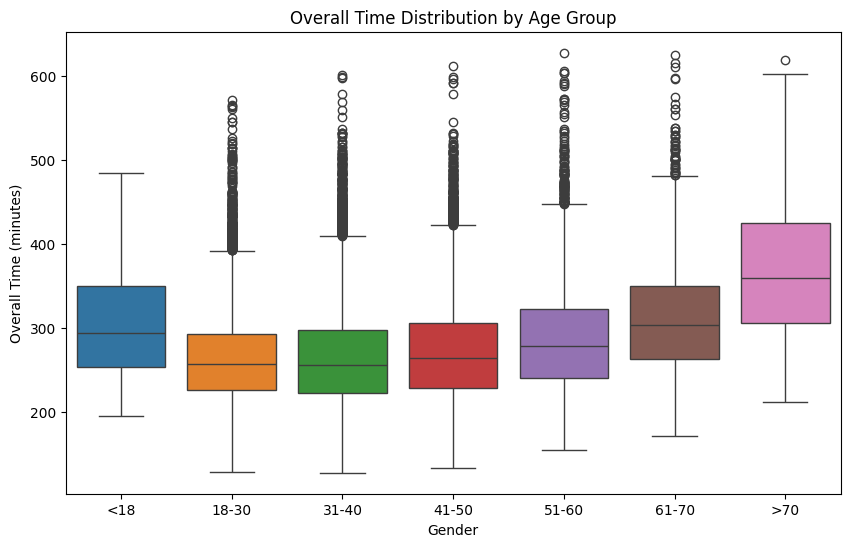

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=marathon, 
    x='ageGroup', 
    y=marathon['overallTime'].dt.total_seconds() / 60, 
    hue = 'ageGroup',
    palette='tab10'
)
plt.title('Overall Time Distribution by Age Group')
plt.xlabel('Gender')
plt.ylabel('Overall Time (minutes)')
plt.show()

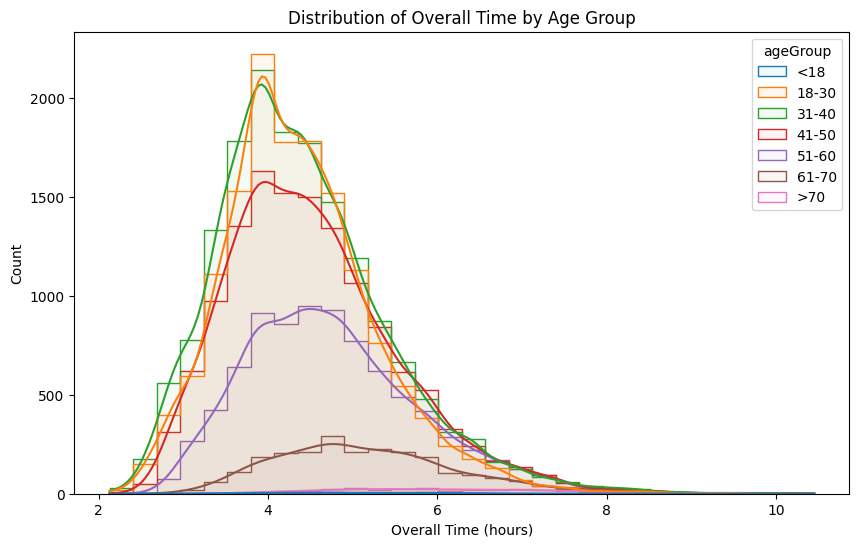

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=marathon, 
    x=marathon['finishTime_hours'], 
    bins=30, 
    kde=True, 
    hue='ageGroup',
    palette='tab10', 
    alpha=.05, 
    element='step')


plt.title("Distribution of Overall Time by Age Group")
plt.xlabel('Overall Time (hours)')
plt.ylabel('Count')

plt.show()

Although the box plot indicates different finish time means for the age groups, the density plot only shows that there is a lower number of runners in the higher age groups and an insignificantly higher mean. However, lets look at a scatter plot to verify this

### D.3 Does Age Have Any Relationship to Performance? <a class="anchor" id="D3"></a>

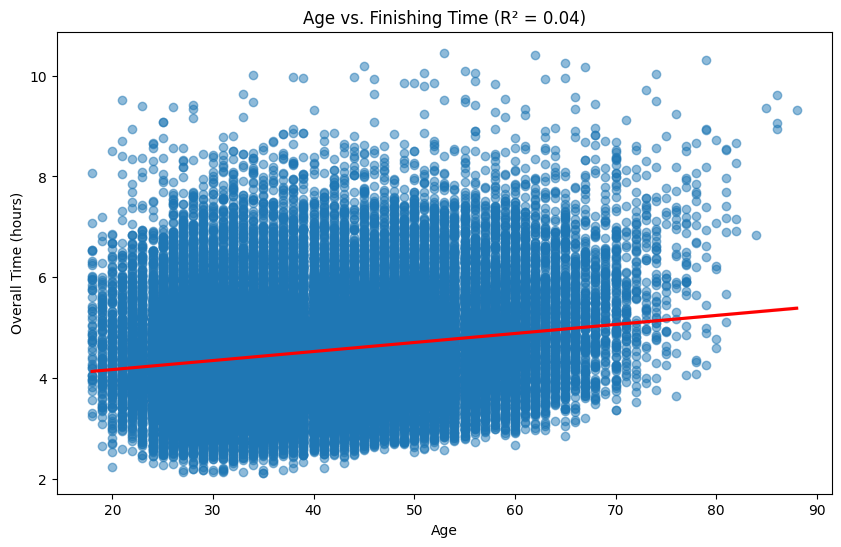

In [27]:
r, _ = stats.pearsonr(marathon['age'], marathon['finishTime_hours'])
r_squared = r**2


plt.figure(figsize=(10, 6))
sns.regplot(data=marathon, x='age',
            y=marathon['finishTime_hours'],
            scatter_kws={'alpha': 0.5},
            line_kws={'color':'red'})
plt.title(f"Age vs. Finishing Time (R² = {r_squared:.2f})")
plt.xlabel("Age")
plt.ylabel("Overall Time (hours)")
plt.show()

Turns out age has nothing to do with runners' finishing times. The r² value is low enough to confidently say that there is no correlation. This isn't too surprising because the marathon has a vast number of runners, all running for different reasons. Some runners travel to run competitively, some run with their friends and family, and some just run because why not.

### D.4 Does More Experience Improve Performance? <a class="anchor" id="D4"></a>

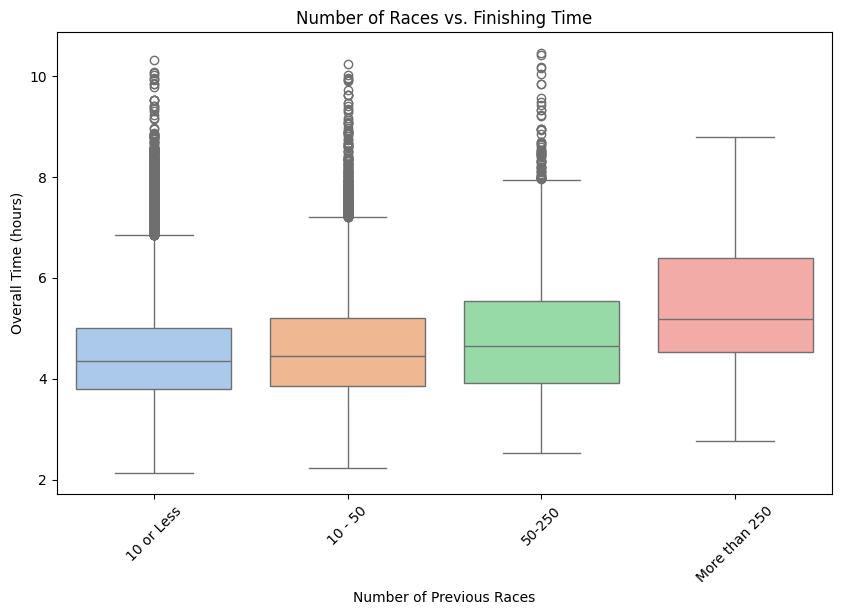

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=marathon, 
            x=pd.cut(marathon['racesCount'],
                     bins =[0,10,50,250,10000],
                     labels=["10 or Less","10 - 50","50-250","More than 250"]),
            y=marathon['finishTime_hours'],
            hue = pd.cut(marathon['racesCount'],
                     bins =[0,10,50,250,10000],
                     labels=["10 or Less","10 - 50","50-250","More than 250"]),
           palette = "pastel")
plt.title("Number of Races vs. Finishing Time")
plt.xlabel("Number of Previous Races")
plt.ylabel("Overall Time (hours)")
plt.xticks(rotation=45)
plt.show()

# E) Conclusion <a class="anchor" id="E"></a>

 This project provided a detailed exploration of the NYC 2024 Marathon dataset, uncovering  insights into the demographics and performance of the runners. The analysis began with data cleaning and preprocessing, followed by an exploratory data analysis that examined distributions of finishing times, pace, and demographic factors such as age and gender.

### Key findings include:

#### Demographic Trends:
The dataset revealed a diverse group of marathon participants, with variations in age and gender distributions. For example, we found that there were almost an equal proportion of Male and Female participants, but there was clearly a larger proportion of runners who were in their 20s. With the use of plotly visualizations, we understood that most runners were from the United States; specifically from New York and New Jersey. However, many runners were from other countries such as Italy, France, and the United Kingdom.

### Performance Analysis:
 A Mann-Whitney U hypothesis test comparing male and female finishing times revealed a statistically significant difference. The Common Language Effect Size (CLES) of 0.346 indicates that male runners generally finished faster than female runners, with a 65.4% chance that a randomly selected male will outperform a randomly selected female. Additionally, we observed that age groups and age had no significant relation to finishing times.

#### Visualization and Communication:
 A range of visualizations: histograms, boxplots, scatter plots, and choropleth maps—were developed to effectively communicate these insights. These tools not only helped identify key trends in the data but also provided a foundation for deeper investigations into runner performance.

#### Future Directions

 While this project has uncovered important trends, additional data would be extremely valuable. For example, a runner's previous race times would enable the building of a machine learning model to predict runner's finishing times. Or split times would give us more insights to runner performance in the first and second halves.
